In [106]:
import pandas as pd 
import numpy as np
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
from tensorflow import keras

from tensorflow.keras import layers, metrics
from sklearn.ensemble import RandomForestRegressor

In [59]:
def load_data(em_data = True, veh_data = True, air_data = True):
    args = []
    if em_data:
        EU_em_df = pd.read_excel('Data/EU_em.xlsx',engine='openpyxl')
        EU_em_annual_df = pd.read_csv('Data/EU_em_annual.csv',)
        UK_em_df = pd.read_excel('Data/UK_em.ods', nrows = 16)
        US_em_df = pd.read_excel('Data/US_em.xlsx',engine='openpyxl')
        # Emissions data Processing
        EU_em_df = EU_em_df.set_index('Month')
        EU_em_annual_df = EU_em_df.groupby(np.arange(len(EU_em_df))//(12)).sum()
        EU_em_annual_df.index = np.linspace(1973, 2021, EU_em_annual_df.shape[0], dtype=np.int32)
        UK_em_df = UK_em_df.transpose()
        UK_em_df.columns = UK_em_df.iloc[0, :]
        UK_em_df = UK_em_df.drop('Year')
        US_em_df = US_em_df.transpose()
        US_em_df.columns = US_em_df.iloc[0, :]
        US_em_df = US_em_df.drop('Gas/Vehicle')
        args += [EU_em_df, EU_em_annual_df, UK_em_df, US_em_df]
    if veh_data:
        EU_veh_df = pd.read_csv('Data/EU_veh.csv')
        UK_veh_df = pd.read_excel('Data/UK_veh.ods', nrows= 76)
        US_veh_df = pd.read_excel('Data/US_veh.xlsx')
        args += [EU_veh_df, UK_veh_df, US_veh_df]
    if air_data:
        # Secondary Data 
        # Air pollution
        # UK 1970-2019/2022
        UK_nox_annual_df = pd.read_csv('Data/Figure06_NOx_time_series.csv')
        UK_pm_all_annual_df = pd.read_csv('Data/Figure03_PM_time_series.csv')
                
        # USA Since 1970-2020, plz Access through column id(numbers)
        USA_nox_annual_df = pd.read_csv('Data/US_nox_em_time_series.csv') # National Emissions Totals (thousands of tons)
        USA_pm_10_annual_df = pd.read_csv('Data/US_pm10_year.csv')        #
        USA_pm_2_5_annual_df = pd.read_csv('Data/US_pm2_5_year.csv')
        
        USA_pm_2_5_annual_df = USA_pm_2_5_annual_df.transpose()
        USA_pm_10_annual_df = USA_pm_10_annual_df.transpose()
                
        # OCED DATA
        OCED_PM10_df = pd.read_excel('Data/PM10_ROAD_OCED_WORLD_DATA.xlsx')
        OCED_NOX_df = pd.read_excel('Data/NOX_ROAD_OCED_WORLD_DATA.xlsx')
        OCED_PM2_5_df = pd.read_excel('Data/PM2_5_ROAD_OCED_WORLD_DATA.xlsx')
    
    args += [UK_nox_annual_df,UK_pm_all_annual_df,USA_pm_10_annual_df,USA_pm_2_5_annual_df,USA_nox_annual_df,OCED_PM10_df,OCED_NOX_df,OCED_PM2_5_df]
        
    return args

def train_test_split(X, y, split_point):
    x_train = X[:split_point, :, :]
    x_test = X[split_point:, :, :]
    y_train = y[:split_point]
    y_test = y[split_point:]
    return x_train, x_test, y_train, y_test

def normalise(X):
    X_attrs = np.zeros((X.shape[-1], 2))
    for i in range(X.shape[-1]):
        X_attrs[i, :] = [np.mean(X[:, i]), np.var(X[:, i])]
        X[:, i] = (X[:, i] - np.mean(X[:, i]))/np.var(X[:, i])**0.5
    return X, X_attrs
        
def create_model(layers, input_shape):
    # Create and compile model
    model = keras.Sequential(layers)
    model.build(input_shape=input_shape)
    model.compile(loss='mse', optimizer='adam')
    model.summary()
    return model

In [6]:
args = load_data()
EU_em_df, EU_em_annual_df, UK_em_df, US_em_df, EU_veh_df, UK_veh_df, US_veh_df, UK_nox_annual_df,UK_pm_all_annual_df,USA_pm_10_annual_df,USA_pm_2_5_annual_df,USA_nox_annual_df,OCED_PM10_df,OCED_NOX_df,OCED_PM2_5_df = args


C:\Apps\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [126]:
time_step = 1
data_memory = 5
epochs = 10
batch_size = 10
df_model_columns =  ['time_step', 'data_memory', 'samples', 'layers', 'epochs', 'batch_size', 'training_loss', 'val_loss', 'test_loss']
#model_df = pd.DataFrame(model_performance).transpose()
#model_df.to_csv('model_performance.csv')
X = EU_em_df.to_numpy()
X_norm, X_attrs = normalise(X)
X_norm, y_norm = np.split(X, [11], 1)
y_norm = np.roll(y_norm, -time_step)
nrows = X_norm.shape[0]
samples = X_norm.shape[1]
X_norm = np.repeat(X_norm, data_memory, 0).reshape(nrows, data_memory, samples)
split_point = int(X_norm.shape[0] *0.75)
x_train, x_test, y_train, y_test = train_test_split(X_norm, y_norm, split_point)

In [150]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Flatten())
    model.add(layers.Dense(units=hp.Int("units", min_value=32, max_value=512, step=32), activation="relu"))
    model.add(layers.Dense(1))
    model.compile(optimizer="adam", loss="mse")
    return model

tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="RNN_em",
    project_name="RNN_em",
)

tuner.search(x_train, y_train, epochs=2, validation_split = 0.1)

# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
input_shape = (x_train.shape[0], data_memory, samples)
best_model.build(input_shape=input_shape)
best_model.summary()

Trial 3 Complete [00h 00m 01s]
val_loss: 0.19346514344215393

Best val_loss So Far: 0.17589035630226135
Total elapsed time: 00h 00m 04s
INFO:tensorflow:Oracle triggered exit
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (439, 55)                 0         
                                                                 
 dense (Dense)               (439, 320)                17920     
                                                                 
 dense_1 (Dense)             (439, 1)                  321       
                                                                 
Total params: 18,241
Trainable params: 18,241
Non-trainable params: 0
_________________________________________________________________


In [96]:
input_shape = (x_train.shape[0], data_memory, samples)
model_layer = [layers.Dense(32, activation='sigmoid'),
               layers.GRU(32, activation='sigmoid', recurrent_activation='sigmoid', ),
               layers.Dense(1)]
model_des = 'D32, GRU32, D1'
model = create_model(model_layer, input_shape)
history = model.fit(x_train, y_train, validation_split = 0.1, epochs= epochs , batch_size=batch_size)
y_pred_norm = np.concatenate((model.predict(x_train[:, :, :]), model.predict(x_test[:, :, :])))
mse = metrics.MeanSquaredError()
mse.update_state(y_norm, y_pred_norm)
test_loss = mse.result().numpy()
y = (y_norm/X_attrs[-1, 1]**0.5) + X_attrs[-1, 0]
y_pred = np.roll(y_pred_norm /X_attrs[-1, 1]**0.5 + X_attrs[-1, 0] , -time_step)
print(test_loss)
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]
model_performance = [time_step, data_memory, samples, model_des, epochs, batch_size, train_loss, val_loss, test_loss]
df_model = pd.DataFrame(model_performance).transpose()
df_model.columns = df_model_columns
df_model.to_csv('model_performance.csv', mode = 'a', header= False)

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_92 (Dense)            (439, 5, 32)              384       
                                                                 
 gru_44 (GRU)                (439, 128)                62208     
                                                                 
 dense_93 (Dense)            (439, 1)                  129       
                                                                 
Total params: 62,721
Trainable params: 62,721
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
40/40 [==============================] - 2s 9ms/step - loss: 0.7951 - val_loss: 1.6579
Epoch 2/10
40/40 [==============================] - 0s 4ms/step - loss: 0.3425 - val_loss: 0.5022
Epoch 3/10
40/40 [==============================] - 0s 4ms/step - loss: 0.1322 - val_loss: 0.2365
Epoch 4/10
40/40 [=

439

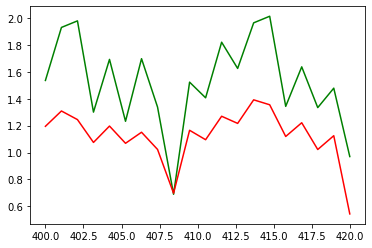

In [92]:
plot_range = [400]
plot_range += [plot_range[0] + 20]
t = np.linspace(plot_range[0], plot_range[1], plot_range[1] - plot_range[0])
plt.plot(t, y[plot_range[0] : plot_range[1]], 'g', t, y_pred[plot_range[0]: plot_range[1]], 'r')
split_point